The Seq2Seq that allows bidirectional comunication states $\leftrightarrow$ laws, with aligned embeddings.

In [1]:
import random
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import networkx as nx 
import pylab

from gensim.models import Word2Vec
from sklearn.decomposition import PCA

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

import keras.backend as K

Using TensorFlow backend.


In [2]:
class GraphLanguage:
    def __init__(self, dataset_size, num_states, max_sequence_size, connection):
        self.dataset_size = dataset_size
        self.max_sequence_size = max_sequence_size
        self.num_states = num_states
        self.connection = connection
    def generate_graph(self):
        G = nx.DiGraph()
        H = range(1,self.num_states+1)
        G.add_nodes_from(H)
        list_of_edges =[]
        edge_labels = {}
        for i in range(1, self.num_states):
            for j in range(1, self.num_states+1):
                d = np.random.randn()
                if d < self.connection and i != j:
                    e = (i,j)
                    list_of_edges.append(e)
                    edge_labels[e] = str(i)+'e'+str(j)
        G.add_edges_from(list_of_edges)
        # connection  = -1.25
        nx.draw(G,pos = nx.spring_layout(G), with_labels=True) 
        pylab.show()
  
        sample_events = []
        sample_relations = []
        sample = []
        target_events = []
        target_events_inputs = []
        target_texts = []
        target_texts_inputs = []
        for _ in range(self.dataset_size):
            sequence_list = []
            sample_rel = []
            sequence_size = random.randint(1, self.max_sequence_size)
            l_descendants = []
            target_event_input = []
            target_event = []
            node = random.randint(1, self.num_states)
            l_descendants.append(node)
            successors = G.successors(node)
            l_successors = list(successors)
            while l_successors and (len(l_descendants) <= sequence_size): 
                successor = random.choice(l_successors)
                node = successor
                l_descendants.append(node)
                successors = G.successors(node)
                l_successors = list(successors)
                str_descendants = [str(item) for item in l_descendants]
                #sequence_list.append(l_descendants)
            for j in range(len(str_descendants)-1):
                rel_list = str_descendants[j]+'s'+str_descendants[j+1]
                sample_rel.append(rel_list)
            a = '<sos>'
            b = '<eos>'
            sample_relations.append(sample_rel)
            sample_events.append(str_descendants)
            
            target_event_input = str_descendants
            target_event = str_descendants
            
            target_event_input = [a] + target_event_input 
            target_event = target_event + [b]
            
            target_events.append(target_event)
            target_events_inputs.append(target_event_input)
            
            sample.append((str_descendants, sample_rel))
            
            target_text = sample_rel
            target_text_input = sample_rel
            
            target_text_input = [a] + target_text_input
            target_text = target_text + [b]
            
            target_texts.append(target_text)
            target_texts_inputs.append(target_text_input)
        return sample, sample_events, sample_relations,target_events, target_events_inputs, target_texts, target_texts_inputs

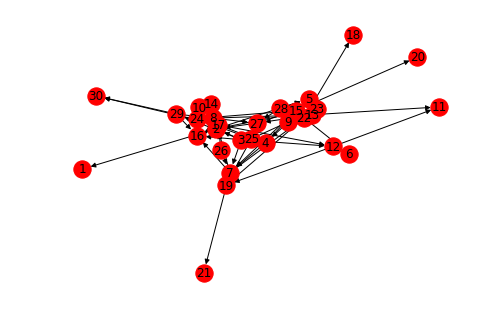

In [3]:
graph = GraphLanguage(10000, 30, 30, -1.5)
sample, sample_events, sample_relations,target_events, target_events_inputs, target_texts, target_texts_inputs = graph.generate_graph()

In [4]:
#print(sample_events)
#print(sample_relations)
#print(sample)
#print(target_texts)
#print(target_texts_inputs)
#print(target_events)
#print(target_events_inputs)

In [5]:
BATCH_SIZE = 16  # Batch size for training.
EPOCHS = 20  # Number of epochs to train for.
LATENT_DIM = 120  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000  # Number of samples to train on.
MAX_SEQUENCE_LENGTH = 30
MAX_NUM_WORDS = 100
EMBEDDING_DIM = 10

In [6]:
samples = sample_events + sample_relations
tokenizer_inputs = Tokenizer(num_words = MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(samples)
input_sequences = tokenizer_inputs.texts_to_sequences(samples)

In [7]:
word2idx_inputs = tokenizer_inputs.word_index # change name states2idx
print('Found {} unique input states.'.format(len(word2idx_inputs))) #test
#word2idx_inputs

Found 86 unique input states.


In [8]:
max_len_input = max(len(s) for s in input_sequences)

In [9]:
print(max_len_input)

31


In [10]:
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
evs = target_events + target_events_inputs
txt = target_texts + target_texts_inputs
tokenizer_outputs.fit_on_texts(txt + evs) 
targets = target_texts + target_events
targets_inputs = target_texts_inputs + target_events_inputs
target_sequences = tokenizer_outputs.texts_to_sequences(targets)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(targets_inputs)

In [11]:
word2idx_outputs = tokenizer_outputs.word_index
print('Found {} unique output relations.'.format(len(word2idx_outputs)))

Found 88 unique output relations.


In [12]:
num_words_output = len(word2idx_outputs) + 1
max_len_target = max(len(s) for s in target_sequences)
max_len_target

32

In [13]:
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

encoder_inputs.shape: (20000, 31)
encoder_inputs[0]: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  5  2  1
  5  2  1  9  7 26  9]


In [14]:
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_inputs[0]: [ 2 36  8  5 20  8  5 21 12 45 52  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
decoder_inputs.shape: (20000, 32)


In [15]:
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

In [16]:
emb_model1 = Word2Vec(sample_events, size = 10, workers = 2, sg = 1, min_count=1)
emb_model2 = Word2Vec(sample_relations, size = 10, workers = 2, sg = 1, min_count = 1)
probes = np.concatenate([sample_events, sample_relations])
#random.shuffle(probes)
emb_model5 = Word2Vec(probes, size = 10, workers = 2, sg = 1, min_count = 1)
emb_model = Word2Vec(sample_events + sample_relations, size = 10, workers = 2, sg = 1, min_count=1) 

In [17]:
words1 = list(emb_model1.wv.vocab)
words2 = list(emb_model2.wv.vocab)
words5 = list(emb_model5.wv.vocab)
words = list(emb_model.wv.vocab)

In [21]:
# Reducing the number of words for the relations embedding
n = len(words1)
import collections
word2word_num = {}
for sequence in sample_relations:
    for word in sequence:
        if word not in word2word_num:
            word2word_num[word] = 0 
        word2word_num[word] += 1
word_counter = collections.Counter(word2word_num)
most_common_words = []
common_words = word_counter.most_common(n)
most_common_words = [words for words, counts in common_words]

state2vec1 = {}
for s in words1:
    state2vec1[s] = emb_model1.wv.__getitem__(s)
state2vec2 = {}
for s in words2:
    state2vec2[s] = emb_model2.wv.__getitem__(s)
word2vec = {}
for s in words:
    word2vec[s] = emb_model.wv.__getitem__(s)

In [23]:
X1 = emb_model1.wv.__getitem__(emb_model1.wv.vocab)
X2 = emb_model2.wv.__getitem__(emb_model2.wv.vocab)
X5 = emb_model5.wv.__getitem__(emb_model5.wv.vocab)

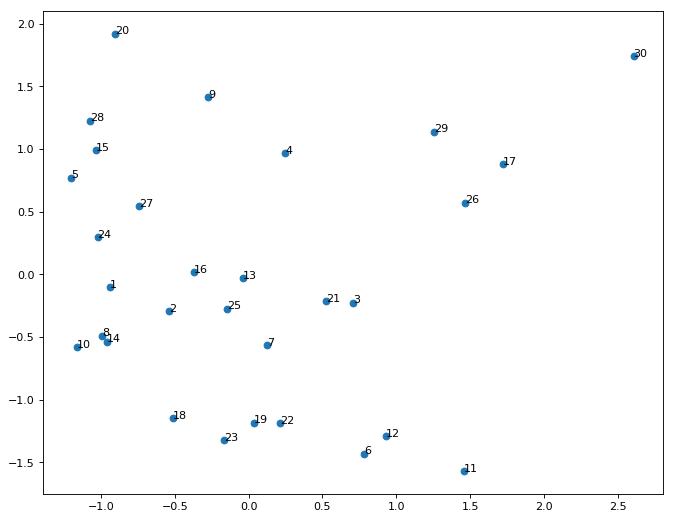

In [26]:
#print(word2vec)
X = emb_model.wv.__getitem__(emb_model.wv.vocab)
pca = PCA(n_components=2, whiten = True)
result = pca.fit_transform(X)
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(result1[:, 0], result1[:, 1])
words = list(emb_model.wv.vocab)
for i, word in enumerate(words1):
    plt.annotate(word, xy=(result1[i, 0], result1[i, 1]))
plt.show()

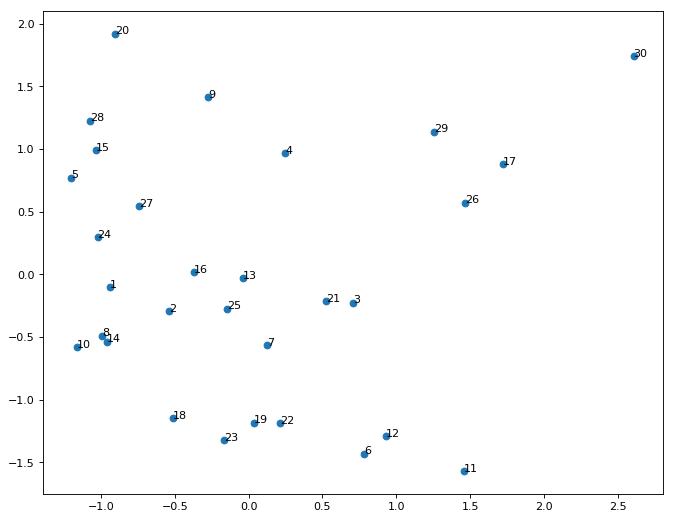

In [27]:
#print(word2vec)
X1 = emb_model1.wv.__getitem__(emb_model1.wv.vocab)
pca = PCA(n_components=2, whiten = True)
result1 = pca.fit_transform(X1)
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(result1[:, 0], result1[:, 1])
words1 = list(emb_model1.wv.vocab)
for i, word in enumerate(words1):
    plt.annotate(word, xy=(result1[i, 0], result1[i, 1]))
plt.show()

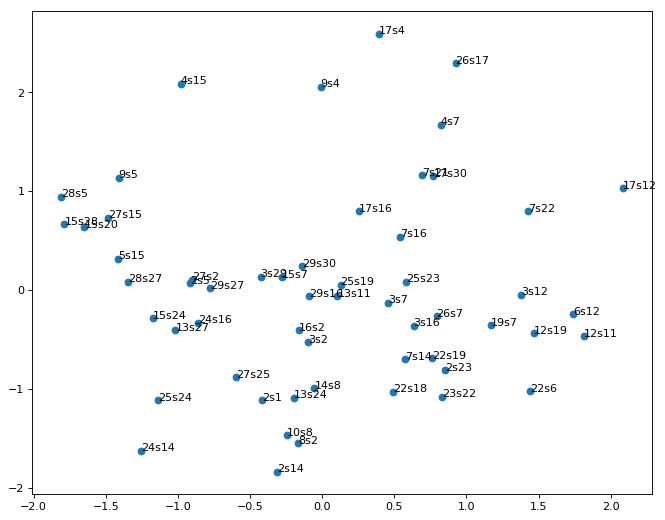

In [28]:
#print(word2vec)
X2 = emb_model2.wv.__getitem__(emb_model2.wv.vocab)
pca = PCA(n_components=2, whiten = True)
result2 = pca.fit_transform(X2)
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(result2[:, 0], result2[:, 1])
words2 = list(emb_model2.wv.vocab)
for i, word in enumerate(words2):
    plt.annotate(word, xy=(result2[i, 0], result2[i, 1]))
plt.show()

In [29]:
state2vec3 = {}
for s in most_common_words:
    state2vec3[s] = state2vec2[s]
X3 = [vec for word, vec in state2vec3.items()]
X3 = np.asarray(X3)
print(X3.shape)
print(X1.shape)

(30, 10)
(30, 10)


In [30]:
from scipy.linalg import orthogonal_procrustes
R, sca = orthogonal_procrustes(X3, X1)
X4 = X3.dot(R)
X5 = X2.dot(R)
X5

array([[ 0.24863139,  0.26250046, -0.6361254 , -0.22513075, -0.29159203,
         0.25720063, -0.6803947 , -0.1868924 , -0.908218  ,  0.2008265 ],
       [ 0.11539733, -0.16056027, -1.1162279 , -0.10762128, -0.53940237,
         0.03741103, -0.56893057, -0.71567935, -0.3520432 ,  0.503781  ],
       [-0.0723972 ,  0.14972174, -0.96616113, -0.28895766, -0.17091215,
        -0.22124422, -0.3805682 , -0.5671239 , -0.4541193 ,  1.106025  ],
       [ 0.16030145, -0.02636874, -1.0596019 , -0.6463108 ,  0.04638094,
         0.4037651 , -0.6224761 , -0.16601309, -0.6400697 ,  0.80924755],
       [-0.01836914,  0.00520262, -0.26546973, -0.44324404, -0.21809366,
         0.3889895 , -1.2869005 , -0.16317545, -0.10447657,  0.5932635 ],
       [-0.3241758 , -0.00731155, -0.41041747, -0.9208711 , -0.47817904,
         0.37669328, -1.1458654 , -0.0174886 ,  0.06427789,  0.6223817 ],
       [-0.22871673,  0.36178392,  0.13350229, -1.1622766 , -0.31231973,
         0.11498933, -1.188423  , -0.84612674

In [31]:
state2vec5 = {}
state2vec5 = state2vec2
for i, j in enumerate(state2vec5):
    state2vec5[j] = X5[i,:]
state2vec5

{'7s14': array([ 0.24863139,  0.26250046, -0.6361254 , -0.22513075, -0.29159203,
         0.25720063, -0.6803947 , -0.1868924 , -0.908218  ,  0.2008265 ],
       dtype=float32),
 '14s8': array([ 0.11539733, -0.16056027, -1.1162279 , -0.10762128, -0.53940237,
         0.03741103, -0.56893057, -0.71567935, -0.3520432 ,  0.503781  ],
       dtype=float32),
 '8s2': array([-0.0723972 ,  0.14972174, -0.96616113, -0.28895766, -0.17091215,
        -0.22124422, -0.3805682 , -0.5671239 , -0.4541193 ,  1.106025  ],
       dtype=float32),
 '2s14': array([ 0.16030145, -0.02636874, -1.0596019 , -0.6463108 ,  0.04638094,
         0.4037651 , -0.6224761 , -0.16601309, -0.6400697 ,  0.80924755],
       dtype=float32),
 '2s5': array([-0.01836914,  0.00520262, -0.26546973, -0.44324404, -0.21809366,
         0.3889895 , -1.2869005 , -0.16317545, -0.10447657,  0.5932635 ],
       dtype=float32),
 '5s15': array([-0.3241758 , -0.00731155, -0.41041747, -0.9208711 , -0.47817904,
         0.37669328, -1.1458654

In [32]:
state2vec6 = {**state2vec1, **state2vec5}
state2vec6

{'7': array([-0.16921517,  0.3313596 , -0.38308647, -0.35007694, -0.39797884,
        -0.42269325, -0.294349  , -0.4907067 , -0.39227977,  0.9061017 ],
       dtype=float32),
 '14': array([ 0.14609522,  0.20032471, -0.93695885,  0.21956854, -0.5437358 ,
         0.33067346, -0.93216604, -0.16262797, -0.45537102,  0.19407605],
       dtype=float32),
 '8': array([-0.32371473,  0.18774632, -0.8381048 , -0.19883811, -0.48746017,
         0.51241654, -0.66255903,  0.07957238, -0.6443755 ,  0.57189935],
       dtype=float32),
 '2': array([-0.13127665,  0.231062  , -1.0374521 , -0.42132956, -0.12529354,
         0.5708828 , -0.67078805, -0.17996779, -0.24761444,  0.2238233 ],
       dtype=float32),
 '5': array([ 0.42012417,  0.3346323 , -0.40624994, -0.169521  ,  0.00950984,
         0.23529048, -0.85237116,  0.11935586, -1.2095678 ,  0.12684171],
       dtype=float32),
 '15': array([ 0.1622701 ,  0.7744402 , -0.45268002,  0.04920814,  0.08551706,
        -0.34778613, -0.79749507,  0.19814213

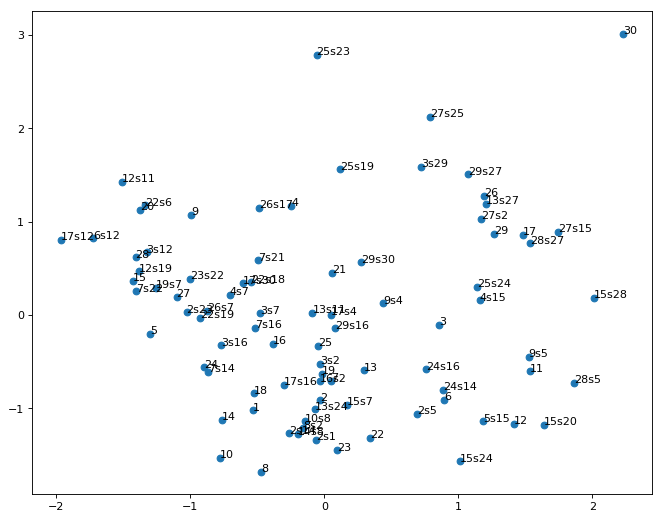

In [33]:
X6 = [vec for word, vec in state2vec6.items()]
pca = PCA(n_components=2, whiten = True)
result6 = pca.fit_transform(np.array(X6))
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(result6[:, 0], result6[:, 1])
words6 = [word for word, vec in state2vec6.items()] 
for i, word in enumerate(words6):
    plt.annotate(word, xy=(result6[i, 0], result6[i, 1]))
plt.show()

In [34]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words + 1, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    embedding_vector = state2vec6.get(word)
    embedding_matrix[i] = embedding_vector

In [35]:
embedding_layer = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length = max_len_input,
                            trainable=False)

In [36]:
decoder_targets_one_hot = np.zeros((len(sample_relations + sample_events), max_len_target, num_words_output), dtype='float32')

In [37]:
for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [47]:
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LATENT_DIM, return_state=True, dropout=0.5)

In [48]:
encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]
decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

In [49]:
decoder_lstm = LSTM(LATENT_DIM, return_sequences = True, return_state = True, dropout=0.5)

In [50]:
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state = encoder_states)

In [51]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [52]:
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

In [53]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
r = model.fit([encoder_inputs, decoder_inputs],
              decoder_targets_one_hot,
              batch_size = BATCH_SIZE,
              epochs=EPOCHS,
              validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/20
16000/16000 [==============================] - 126s 8ms/step - loss: 0.6105 - acc: 0.8524 - val_loss: 0.3228 - val_acc: 0.8875
Epoch 2/20
16000/16000 [==============================] - 120s 8ms/step - loss: 0.2931 - acc: 0.8971 - val_loss: 0.3022 - val_acc: 0.8873
Epoch 3/20
16000/16000 [==============================] - 120s 8ms/step - loss: 0.2754 - acc: 0.9012 - val_loss: 0.2515 - val_acc: 0.9071
Epoch 4/20
16000/16000 [==============================] - 119s 7ms/step - loss: 0.2220 - acc: 0.9230 - val_loss: 0.2148 - val_acc: 0.9211
Epoch 5/20
16000/16000 [==============================] - 119s 7ms/step - loss: 0.2028 - acc: 0.9292 - val_loss: 0.1982 - val_acc: 0.9243
Epoch 6/20
16000/16000 [==============================] - 119s 7ms/step - loss: 0.1929 - acc: 0.9322 - val_loss: 0.1940 - val_acc: 0.9255
Epoch 7/20
16000/16000 [==============================] - 120s 7ms/step - loss: 0.1823 - acc: 0.9363 - val_loss: 0.1818 - v

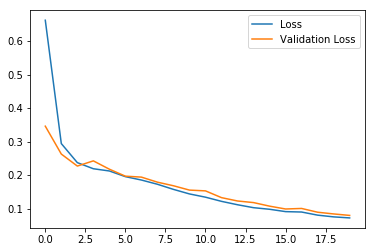

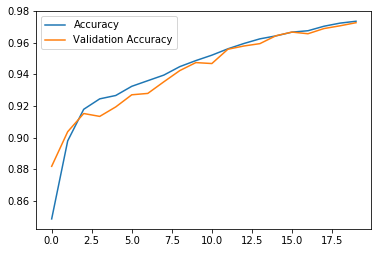

In [79]:
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.plot(r.history['acc'], label='Accuracy')
plt.plot(r.history['val_acc'], label='Validation Accuracy')
plt.legend()
plt.show()

In [80]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)
decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [81]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [82]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

In [83]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [84]:
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [85]:
idx2state = {v:k for k, v in word2idx_inputs.items()}
idx2relation = {v:k for k, v in word2idx_outputs.items()}

In [86]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    # Create the language formulation
    output_sentence = []
    for _ in range(max_len_target):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])
        if eos == idx:
            break
        word = ''
        if idx > 0:
            word = idx2relation[idx]
            output_sentence.append(word)
            target_seq[0, 0] = idx
            states_value = [h, c]
    return ' '.join(output_sentence)

In [87]:
while True:
    # Test description of physical system
    samples = sample_events + sample_relations
    i = np.random.choice(len(samples))
    input_seq = encoder_inputs[i:i+1] 
    relation = decode_sequence(input_seq)
    print(encoder_inputs[i:i+1])
    print('-')
    print('Sequence of states:', samples[i])
    print('Language formulation:', relation)

    ans = input("Continue? [y/n]")
    if ans and ans.lower().startswith('n'):
        break

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0 74 39 33 21]]
-
Sequence of states: ['26s3', '3s13', '13s25', '25s22']
Language formulation: 26 3 13 25 22
Continue? [y/n]y
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0 11  8  6 34]]
-
Sequence of states: ['12', '1', '14', '30']
Language formulation: 12s1 1s14 14s30
Continue? [y/n]y
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0 67]]
-
Sequence of states: ['17s22']
Language formulation: 17 22
Continue? [y/n]n
